# Structured and time series data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
from pandas.io.json import json_normalize
np.set_printoptions(threshold=50, edgeitems=20)

PATH='/home/borowis/s3/'

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
def load_df(csv_path, json_columns=JSON_COLUMNS):

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in json_columns}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [4]:
table_names = ['train', 'test']

In [5]:
tables = [load_df(f'{PATH}{fname}.csv') for fname in table_names]

In [6]:
from IPython.display import HTML, display

In [ ]:
for t in tables: display(t.head())

In [ ]:
for t in tables: display(DataFrameSummary(t).summary())

## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [8]:
train, test = tables

In [9]:
len(train),len(test)

(903653, 804684)

Drop non-unique columns

In [10]:
cols_to_drop = [c for c in train.columns if train[c].nunique()==1]; cols_to_drop

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.bounces',
 'totals.newVisits',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode',
 'trafficSource.isTrueDirect']

In [11]:
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop([col for col in cols_to_drop if col in test.columns], axis=1, inplace=True)

Columns in test set missing from train 

In [12]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  {'totals.transactionRevenue'}


Parse dates correctly

In [13]:
train['date'] = pd.to_datetime(train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
test['date'] = pd.to_datetime(test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
train['visitStartTime'] = pd.to_datetime(train['visitStartTime'], unit='s')
test['visitStartTime'] = pd.to_datetime(test['visitStartTime'], unit='s')

In [14]:
print(f'First date in train set is {train["date"].min()}. Last date in train set is {train["date"].max()}.')
print(f'First date in test set is {test["date"].min()}. Last date in test set is {test["date"].max()}.')

First date in train set is 2016-08-01 00:00:00. Last date in train set is 2017-08-01 00:00:00.
First date in test set is 2017-08-02 00:00:00. Last date in test set is 2018-04-30 00:00:00.


In [15]:
print(f'First date in train set is {train["visitStartTime"].min()}. Last date in train set is {train["visitStartTime"].max()}.')
print(f'First date in test set is {test["visitStartTime"].min()}. Last date in test set is {test["visitStartTime"].max()}.')

First date in train set is 2016-08-01 07:00:12. Last date in train set is 2017-08-02 06:59:53.
First date in test set is 2017-08-02 07:00:03. Last date in test set is 2018-05-01 06:56:58.


The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [16]:
add_datepart(train, "date", drop=False)
add_datepart(test, "date", drop=False)
add_datepart(train, "visitStartTime", time=True, drop=False)
add_datepart(test, "visitStartTime", time=True, drop=False)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [17]:
print ("think about it")

think about it


In [18]:
train.to_feather(f'{PATH}train')
test.to_feather(f'{PATH}test')
#train = pd.read_feather(f'{PATH}train')
#test = pd.read_feather(f'{PATH}test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [ ]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [ ]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [ ]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [ ]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [ ]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [ ]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [ ]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [ ]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [ ]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [ ]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [ ]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [ ]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [ ]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [ ]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [ ]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [ ]:
df.drop(columns,1,inplace=True)

In [ ]:
df.head()

It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [ ]:
df.to_feather(f'{PATH}df')

In [ ]:
df = pd.read_feather(f'{PATH}df')

In [ ]:
df["Date"] = pd.to_datetime(df.Date)

In [ ]:
df.columns

In [ ]:
joined = join_df(joined, df, ['Store', 'Date'])

In [ ]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [ ]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [ ]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [ ]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [19]:
train = pd.read_feather(f'{PATH}train')
test = pd.read_feather(f'{PATH}test')

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [28]:
train.head().T.head(70)

,0,1,2,3,4
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
device.browser,Chrome,Firefox,Chrome,UC Browser,Chrome
device.deviceCategory,desktop,desktop,desktop,desktop,mobile
device.isMobile,False,False,False,False,True
device.operatingSystem,Windows,Macintosh,Windows,Linux,Android
geoNetwork.city,Izmir,not available in demo dataset,Madrid,not available in demo dataset,not available in demo dataset
geoNetwork.continent,Asia,Oceania,Europe,Asia,Europe
geoNetwork.country,Turkey,Australia,Spain,Indonesia,United Kingdom
geoNetwork.metro,(not set),not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset
geoNetwork.networkDomain,ttnet.com.tr,dodo.net.au,unknown.unknown,unknown.unknown,unknown.unknown


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [22]:
contin_vars = ['visitNumber', 'totals.hits', 'totals.pageviews']
no_use = ['fullVisitorId', 'date', 'sessionId', 'visitId', 'visitStartTime', 'visitStartTimeElapsed', 
          'visitStartTimeYear', 'visitStartTimeMonth', 'visitStartTimeWeek', 'visitStartTimeDay', 'visitStartTimeDayofweek',
          'visitStartTimeDayofyear', 'visitStartTimeIs_month_end', 'visitStartTimeIs_month_start', 'visitStartTimeIs_quarter_end',
          'visitStartTimeIs_quarter_start', 'visitStartTimeIs_year_end', 'visitStartTimeIs_year_start', 
          'totals.transactionRevenue']
cat_vars = [col for col in train.columns if col not in contin_vars and col not in no_use]

In [23]:
dep = 'totals.transactionRevenue'
train = train[cat_vars+contin_vars+[dep, 'date']].copy()

In [24]:
test[dep] = 0
test = test[cat_vars+contin_vars+[dep, 'date', 'fullVisitorId']].copy()

In [25]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [26]:
apply_cats(test, train)

In [27]:
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')

In [32]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0).astype('float32')

We're going to run on a sample.

In [35]:
n = len(train)
idxs = get_cv_idxs(n, val_pct=150000/n)
train_samp = train.iloc[idxs].set_index("date")
samp_size = len(train_samp); samp_size

150000

To run on the full dataset, use this instead:

In [83]:
samp_size = n
train_samp = train.set_index("date")

We can now process our data...

In [84]:
train_samp.head(2).T

date,2016-09-02 00:00:00,2016-09-02 00:00:00
channelGrouping,Organic Search,Organic Search
device.browser,Chrome,Firefox
device.deviceCategory,desktop,desktop
device.isMobile,False,False
device.operatingSystem,Windows,Macintosh
geoNetwork.city,Izmir,not available in demo dataset
geoNetwork.continent,Asia,Oceania
geoNetwork.country,Turkey,Australia
geoNetwork.metro,(not set),not available in demo dataset
geoNetwork.networkDomain,ttnet.com.tr,dodo.net.au


In [85]:
df, y, nas, mapper = proc_df(train_samp, 'totals.transactionRevenue', do_scale=True)
yl = np.log1p(y)

In [86]:
test = test.set_index("date")

KeyError: 'date'

In [87]:
df_test, _, nas, mapper = proc_df(test, 'totals.transactionRevenue', do_scale=True, skip_flds=['fullVisitorId'],
                                  mapper=mapper, na_dict=nas)

In [69]:
df.head(2).T

date,2017-01-31 00:00:00,2017-04-02 00:00:00
channelGrouping,5.000000,7.000000
device.browser,41.000000,12.000000
device.deviceCategory,2.000000,1.000000
device.isMobile,2.000000,1.000000
device.operatingSystem,20.000000,17.000000
geoNetwork.city,364.000000,649.000000
geoNetwork.continent,3.000000,5.000000
geoNetwork.country,37.000000,210.000000
geoNetwork.metro,1.000000,94.000000
geoNetwork.networkDomain,1.000000,13557.000000


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [ ]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [42]:
print(f'First date in train set is {df.index.min()}. Last date in train set is {df.index.max()}.')
print(f'First date in test set is {df_test.index.min()}. Last date in test set is {df_test.index.max()}.')

First date in train set is 2016-08-01 00:00:00. Last date in train set is 2017-08-01 00:00:00.
First date in test set is 2017-08-02 00:00:00. Last date in test set is 2018-04-30 00:00:00.


In [88]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2017,8,1)) & (df.index>=datetime.datetime(2017,4,1)))

In [89]:
len(val_idx)

270443

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [90]:
def inv_y(a): return np.expm1(a)

def exp_rmse(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [91]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [92]:
cat_sz = [(c, len(train_samp[c].cat.categories)+1) for c in cat_vars]

In [93]:
cat_sz

[('channelGrouping', 9),
 ('device.browser', 55),
 ('device.deviceCategory', 4),
 ('device.isMobile', 3),
 ('device.operatingSystem', 21),
 ('geoNetwork.city', 650),
 ('geoNetwork.continent', 7),
 ('geoNetwork.country', 223),
 ('geoNetwork.metro', 95),
 ('geoNetwork.networkDomain', 28065),
 ('geoNetwork.region', 377),
 ('geoNetwork.subContinent', 24),
 ('trafficSource.adContent', 45),
 ('trafficSource.adwordsClickInfo.adNetworkType', 3),
 ('trafficSource.adwordsClickInfo.gclId', 17775),
 ('trafficSource.adwordsClickInfo.page', 9),
 ('trafficSource.adwordsClickInfo.slot', 3),
 ('trafficSource.campaign', 11),
 ('trafficSource.keyword', 3660),
 ('trafficSource.medium', 8),
 ('trafficSource.referralPath', 1476),
 ('trafficSource.source', 381),
 ('Year', 3),
 ('Month', 13),
 ('Week', 53),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 367),
 ('Is_month_end', 3),
 ('Is_month_start', 3),
 ('Is_quarter_end', 3),
 ('Is_quarter_start', 3),
 ('Is_year_end', 3),
 ('Is_year_start', 3),
 ('Elapsed'

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [94]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [95]:
emb_szs

[(9, 5),
 (55, 28),
 (4, 2),
 (3, 2),
 (21, 11),
 (650, 50),
 (7, 4),
 (223, 50),
 (95, 48),
 (28065, 50),
 (377, 50),
 (24, 12),
 (45, 23),
 (3, 2),
 (17775, 50),
 (9, 5),
 (3, 2),
 (11, 6),
 (3660, 50),
 (8, 4),
 (1476, 50),
 (381, 50),
 (3, 2),
 (13, 7),
 (53, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (367, 50),
 (25, 13),
 (61, 31),
 (61, 31)]

In [96]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
# m.summary()

In [97]:
m.lr_find()

  0%|          | 16/4947 [00:00<01:10, 70.44it/s, loss=158, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss                                            
    0      3.841045   4.760672  



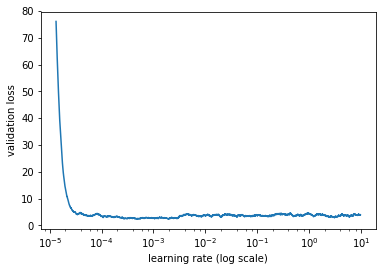

In [98]:
m.sched.plot(100)

### Sample

In [79]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [80]:
m.fit(lr, 3, metrics=[exp_rmse])

  1%|          | 10/822 [00:00<00:08, 97.59it/s, loss=31.6, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                               
    0      3.686023   4.673891   21107658.92297
    1      3.847985   4.673891   21107658.922971                        
    2      3.800248   4.673877   21107658.922975                        



[4.673877357155502, 21107658.92297467]

In [81]:
m.fit(lr, 5, metrics=[exp_rmse], cycle_len=1)

  2%|▏         | 20/822 [00:00<00:08, 97.53it/s, loss=3.93, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                               
    0      2.736455   3.12875    21107205.799341
    1      2.51637    3.094277   21105320.106281                        
    2      2.486494   3.150825   21104778.801246                        
    3      2.108909   3.237899   21076690.116645                        
    4      1.803356   3.395147   21065802.929664                        



[3.3951471178701484, 21065802.929663587]

In [82]:
m.fit(lr, 2, metrics=[exp_rmse], cycle_len=4)

  2%|▏         | 20/822 [00:00<00:08, 96.17it/s, loss=1.32, refresh=0] 

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                               
    0      2.020545   3.560047   21151514.441777
    1      1.991228   3.634333   21036050.030951                       
    2      0.998669   4.026325   21594140.913945                         
    3      0.911956   3.976438   21467943.906566                         
    4      1.465379   3.767708   21076182.43449                         
    5      1.117437   4.411147   21136403.674232                         
    6      0.665317   4.380466   20829896.315324                         
    7      0.565907   4.391373   20807680.306145                         



[4.391372700976275, 20807680.306145314]

### All

In [99]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4/2

In [102]:
m.fit(lr, 1, metrics=[exp_rmse])

  0%|          | 18/4947 [00:00<01:02, 78.92it/s, loss=99.6, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                                 
    0      2.679052   3.268949   15041720.171841



[3.2689486072205014, 15041720.171840752]

In [103]:
m.fit(lr, 3, metrics=[exp_rmse])

  0%|          | 18/4947 [00:00<01:01, 79.90it/s, loss=2.7, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                                 
    0      2.705825   3.094474   15040094.927114
    1      2.252235   3.107229   15039419.820266                          
    2      2.673768   3.03622    15039421.902233                          



[3.0362195318723595, 15039421.902232893]

In [104]:
m.fit(lr, 3, metrics=[exp_rmse], cycle_len=1)

  0%|          | 18/4947 [00:00<01:02, 78.93it/s, loss=1.74, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                                 
    0      2.479366   3.054063   15038234.205787
    1      2.473931   3.052271   15036587.92033                           
    2      2.43412    3.088748   15038442.708954                          



[3.0887480662100852, 15038442.708954407]

In [105]:
m.fit(lr, 2, metrics=[exp_rmse], cycle_len=4)

  0%|          | 17/4947 [00:00<01:05, 74.86it/s, loss=2.5, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                                 
    0      2.23963    3.176344   15039868.521379
    1      2.063369   3.120254   15152533.877355                          
    2      1.97515    3.128007   15065889.855981                          
    3      2.057636   3.140883   15104336.462161                          
    4      2.094354   3.273678   15079626.233435                          
    5      1.94008    3.235933   15096906.809126                          
    6      1.560443   3.246335   15384372.075902                          
    7      1.657346   3.233075   15519867.082087                          



[3.2330754242911475, 15519867.082086653]

### Test

In [106]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4/2

In [107]:
m.fit(lr, 3, metrics=[exp_rmse])

  0%|          | 16/4947 [00:00<01:06, 74.06it/s, loss=113, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                                 
    0      2.478863   3.284501   15041807.604376
    1      2.901272   3.09426    15039400.590141                          
    2      2.670646   3.106072   15041588.359546                          



[3.106072373605788, 15041588.359545663]

In [108]:
m.fit(lr, 3, metrics=[exp_rmse], cycle_len=1)

  0%|          | 18/4947 [00:00<01:05, 75.61it/s, loss=3.42, refresh=0]

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   exp_rmse                                 
    0      2.340502   3.063402   15038707.852342
    1      2.415187   3.070592   15039905.69076                           
    2      1.951431   3.051384   15039835.811711                          



[3.051384320696898, 15039835.811711235]

In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [109]:
x,y=m.predict_with_targs()

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [110]:
exp_rmse(x,y)

66864870.44566897

In [111]:
pred_test=m.predict(True)

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [112]:
pred_test = np.expm1(pred_test)

In [113]:
submission = test[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = pred_test
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
#grouped_test["PredictedLogRevenue"] = np.log1p(grouped_test["PredictedLogRevenue"])
grouped_test.to_csv(f'{PATH}tmp/sub.csv', index=False)

In [ ]:
FileLink(csv_fn)